In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
# calib_maglim = [3974, 6699, 9962, 11139, 12460, 13163, 19871, 
#                 21102, 22277, 26761, 28378, 29128, 38148, 41020, 
#                 41093, 44982, 45084, 46127, 49448, 50073, 53641, 67908, 72228]
# I_maglim = [38803, 39181, 39431, 39619, 40005, 40107, 40147, 40588,
#             40604, 41567, 41829, 42768, 5807403, 5057729, 4002181, 4321374, 37814]


########### Updated list using the color-LogWimx correaltion
calib_maglim = [3974, 6699, 19871, 22277, 28378, 38148, 41020, 41093, 46127, 49448, 53641]
calib_maglim += [6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 44982, 45084, 46127, 67908, 72228]

I_maglim = [38803,   39181,   39431,   39619,   40005,   40107,   40588,   40604,
   41567,   41829,   42768, 5807403, 5057729,   37814]
I_maglim += [38803, 39181, 39431, 40005, 40107, 40147, 41567, 42768, 14548, 14590]

In [3]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

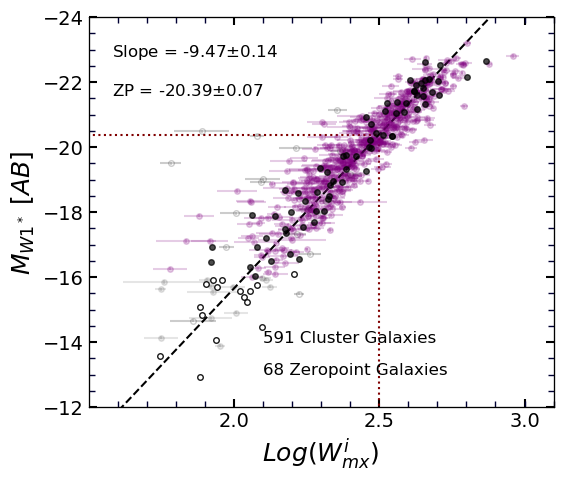

In [4]:
band = 'w1'

fig, ax, Clusters, S_ZP, zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=True,
                                            getZPcalib=True)

In [5]:
slope = S_ZP[0]
slope_e = S_ZP[1]
zp    = S_ZP[2]
zp_e    = S_ZP[3]

print S_ZP

Clusters_orig = allCluster(table, band=band, pgcFaint=I_maglim)

[ -9.46823495   0.14223263 -20.3853545    0.07207729]


In [6]:
d_lst = []
keys = []
for i, key in enumerate(Clusters):
        myCluster = Clusters[key]
        print key, myCluster['slope'], myCluster['zp'], Clusters_orig[key]['zp']-zp, Clusters_orig[key]['name']
        
        d_modulus = Clusters_orig[key]['zp']-zp
        d_lst.append(d_modulus)
        keys.append(key)

print 

indx  = np.argsort(d_lst)

for i in indx:
    key = keys[i]
    print key, '%.1f'%d_lst[i], Clusters_orig[key]['name']

NEST_200092 -9.468234954914562 12.815853099747153 33.08405236456182 Pegasus
NEST_200037 -9.468234954914562 14.167636988870047 34.60573488066062 NGC70
NEST_200017 -9.468234954914562 14.859430161933375 35.15789671862269 Abell 539
NEST_200005 -9.468234954914562 13.605178930552212 33.98145849806273 NGC410
NEST_200006 -9.468234954914562 13.637194041040935 33.998885062331276 NGC507
NEST_100014 -9.468234954914562 12.422586698907581 32.81100905957732 Antlia
NEST_200003 -9.468234954914562 13.511424319050574 33.89458038175452 Abell 262
NEST_100001 -9.468234954914562 14.495232591824456 34.877302548741326 Coma
NEST_100003 -9.468234954914562 12.254119145766515 32.633902398699774 Centaurus
NEST_100002 -9.468234954914562 10.433915811171758 30.920594522004937 Virgo
NEST_100005 -9.468234954914562 14.492177062551956 34.8749298571224 Abell 1367
NEST_200045 -9.468234954914562 14.089882101441818 34.47141829149779 NGC80
NEST_100007 -9.468234954914562 15.684840533522381 36.06081443161297 Abell 2151 (Hercules

In [7]:
def rmsMaker(logWimx, mag, logWimx_e, slope, zp):
    
    mag_fit = slope*(logWimx-2.5)+zp
    rms = np.sqrt(np.mean((mag-mag_fit)**2))
    
    logWimx_f = (mag-zp)/slope+2.5
    RMS = np.abs(slope*(np.sqrt(np.sum((logWimx-logWimx_f)**2/logWimx_e**2)/np.sum(1./logWimx_e**2))))
    
    return rms, RMS
    

Virgo (25) -8.56 0.53 10.54 0.11 10.43 0.10 0.96


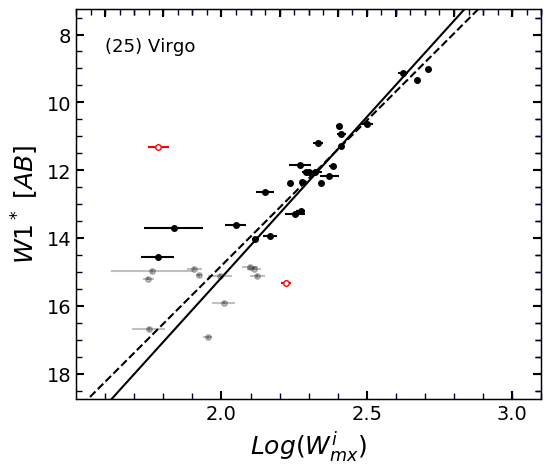

In [8]:
##########################################
def plotSingleCluster(key, xLim = (1.5,3.1), yLim = (18.75,7.25)):
#         key = 'NEST_100002'
    logWimx_, mag_, logWimx_e_, mag_e_ = plotCluster(ax, Clusters, nest=key, plotErrors=True, alpha=1., 
                        markersize=0, pgcFaint=I_maglim, plotWeird=True, color='k', 
                        alphaFaint=0.25, weirdColor='r', alphaWeird=1.)
    
    ## solid line, universal fit
    x = np.linspace(-5,5,50)
    y = slope*(x-2.5)+Clusters[key]['zp']
    ax.plot(x,y, 'k-')  
    
    
    ## dashed line, original fit
    y = Clusters_orig[key]['slope']*(x-2.5)+Clusters_orig[key]['zp']
    ax.plot(x,y, 'k--')  
    
    
    Sorig = Clusters_orig[key]['slope']
    Sorig_e = Clusters_orig[key]['slope_e']
    ZPorig = Clusters_orig[key]['zp']
    ZPorig_e = Clusters_orig[key]['zp_e']
    Zp_univ = Clusters[key]['zp']
    Zp_univ_e = Clusters[key]['zp_e']
    rms, RMS = rmsMaker(logWimx_, mag_, logWimx_e_, slope, Zp_univ)
    print Clusters_orig[key]['name'], '(%d)'%len(logWimx_), '%.2f'%Sorig, '%.2f'%Sorig_e, '%.2f'%ZPorig, '%.2f'%ZPorig_e, '%.2f'%Zp_univ, '%.2f'%Zp_univ_e, '%.2f'%rms
    
    
    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)
    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    
    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     


    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
            
    ax.text(1.6,8.5, r''+"(%d)" % len(logWimx_)+' '+Clusters[key]['name'], fontsize=13)
    
##########################################    
    
    

fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (18.75,7.25))
plotSingleCluster('NEST_100002')

Virgo (25) -8.56 0.53 10.54 0.11 10.43 0.10 0.96
Ursa Major (37) -10.02 0.49 10.77 0.09 10.80 0.08 0.60
Fornax (17) -8.86 0.61 10.88 0.13 10.86 0.14 0.78
Centaurus (23) -10.02 1.32 12.25 0.15 12.25 0.14 0.72
Antlia (17) -9.80 1.05 12.43 0.12 12.42 0.11 0.61
Pegasus (25) -10.19 1.12 12.70 0.22 12.82 0.12 0.64
Hydra (45) -8.19 0.55 13.25 0.09 13.29 0.10 0.89
Abell 262 (55) -8.50 0.64 13.51 0.11 13.51 0.13 0.98
NGC410 (31) -9.93 0.83 13.60 0.11 13.61 0.10 0.64
NGC507 (22) -8.78 0.52 13.61 0.08 13.64 0.08 0.38
Cancer (17) -9.95 0.84 13.80 0.12 13.79 0.11 0.51
NGC80 (13) -9.68 1.23 14.09 0.13 14.09 0.12 0.53
NGC70 (11) -10.23 1.40 14.22 0.16 14.17 0.12 0.42
Abell 1367 (62) -9.70 0.52 14.49 0.06 14.49 0.06 0.59
Coma (75) -10.21 0.48 14.49 0.07 14.50 0.06 0.61
Abell 400 (23) -10.19 0.76 14.55 0.09 14.54 0.08 0.69
NGC4065 (12) -10.21 0.87 14.68 0.12 14.71 0.11 0.53
Abell 539 (22) -8.28 0.66 14.77 0.08 14.86 0.08 0.39
Abell 2634/66 (26) -9.91 0.92 14.97 0.12 14.93 0.08 0.57
Abell 2151 (Hercules

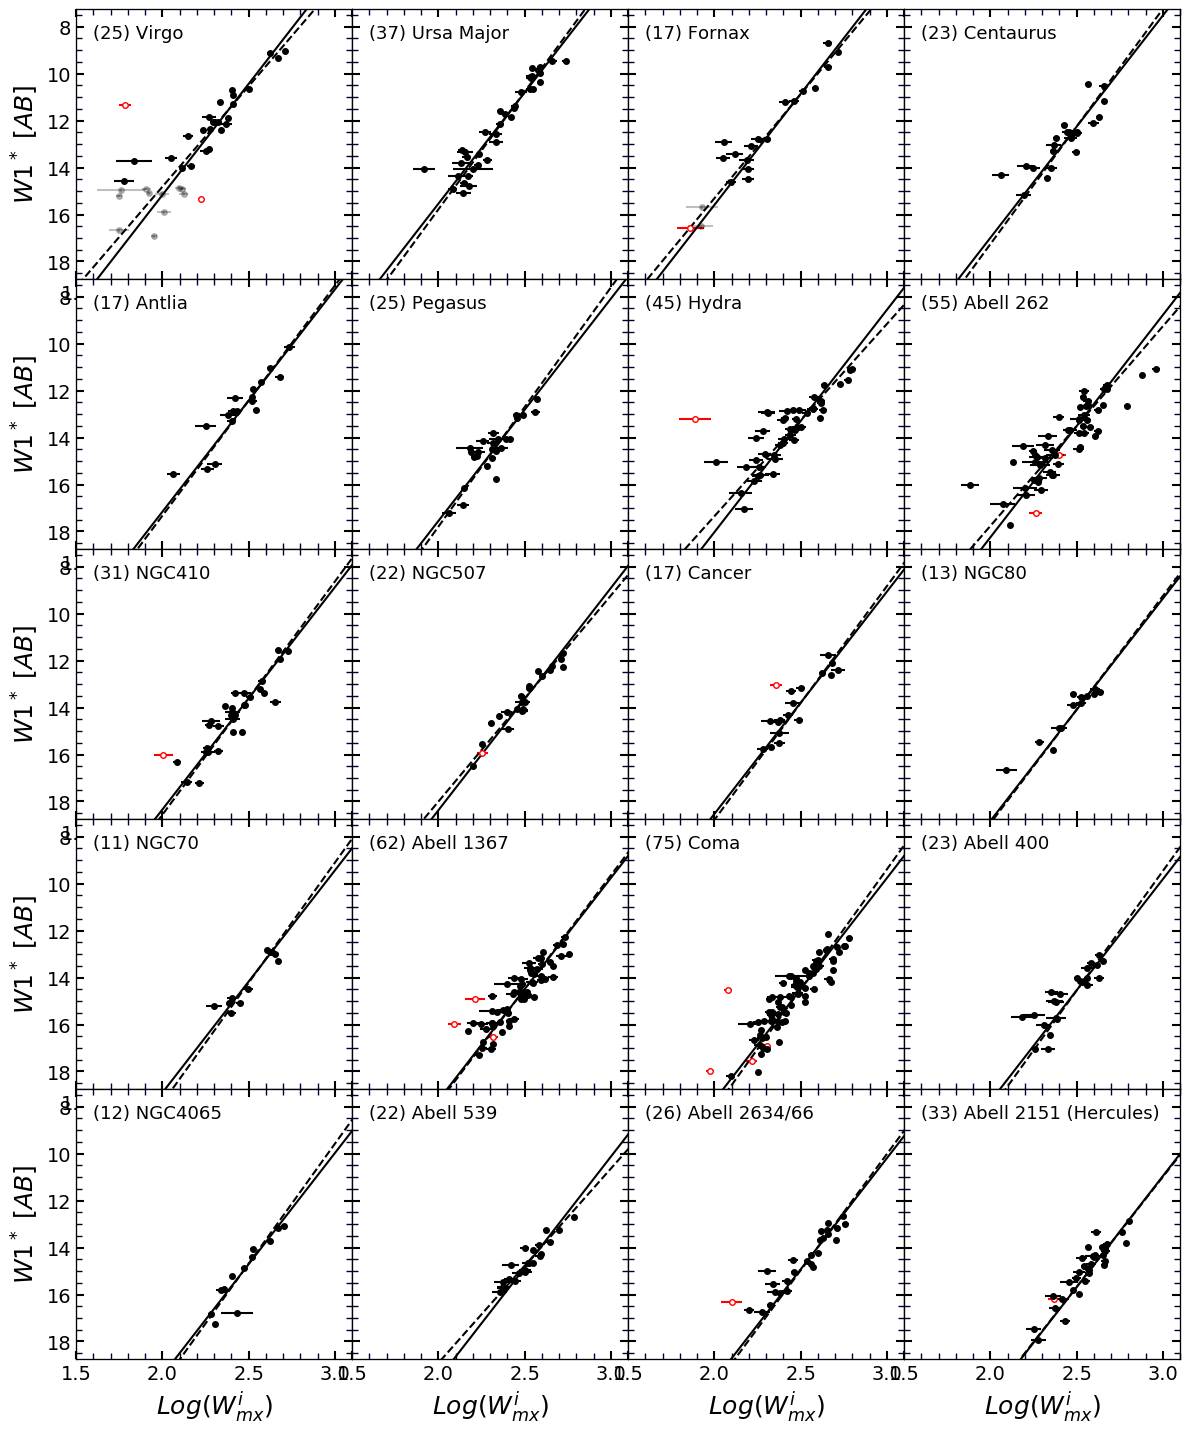

In [9]:
fig = py.figure(figsize=(12, 15), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(5, 4); p=0


for i in indx:
    key = keys[i]
    ax = plt.subplot(gs[p])
    plotSingleCluster(key)
    
    if p%4==0: 
        ax.set_ylabel(r'$'+band.upper()+'^* \/\/ [AB]$', fontsize=18)
    else:
        plt.setp(ax.get_yticklabels(), visible=False) 
        
    if p>15: ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
    p+=1

plt.subplots_adjust(hspace=.0, wspace=0)

In [10]:
for i in indx:
    key = keys[i]
    myCluster = Clusters[key]
    
    mag = myCluster['mag']
    pgc = myCluster['pgc']
    ix = []
    for i, id in enumerate(pgc):
        if not id in I_maglim:
            ix.append(i)  
    
    mags = mag[ix]
    jj = np.argsort(mags)
    
#     print Clusters[key]['name'], mags[jj][::-1][1]
    print mags[jj][::-1][1]
    


14.03
14.92
14.48
14.44
15.34
16.89
16.36
16.83
17.18
15.56
15.68
15.81
15.23
17.05
18.03
17.03
16.84
15.72
16.66
17.46


In [11]:
tmp = []
for i in indx:
    key = keys[i]
    tmp.append(keys[i])
    print key, Clusters[key]['name']
    
print tmp

NEST_100002 Virgo
NEST_100008 Ursa Major
NEST_200015 Fornax
NEST_100003 Centaurus
NEST_100014 Antlia
NEST_200092 Pegasus
NEST_100006 Hydra
NEST_200003 Abell 262
NEST_200005 NGC410
NEST_200006 NGC507
NEST_100030 Cancer
NEST_200045 NGC80
NEST_200037 NGC70
NEST_100005 Abell 1367
NEST_100001 Coma
NEST_200012 Abell 400
NEST_100018 NGC4065
NEST_200017 Abell 539
NEST_200016 Abell 2634/66
NEST_100007 Abell 2151 (Hercules)
['NEST_100002', 'NEST_100008', 'NEST_200015', 'NEST_100003', 'NEST_100014', 'NEST_200092', 'NEST_100006', 'NEST_200003', 'NEST_200005', 'NEST_200006', 'NEST_100030', 'NEST_200045', 'NEST_200037', 'NEST_100005', 'NEST_100001', 'NEST_200012', 'NEST_100018', 'NEST_200017', 'NEST_200016', 'NEST_100007']
